# **Aviachipta Narxini Bashorat Qilish**

### AutoGluon:
- **[AutoGluon](https://auto.gluon.ai/) is an open source AutoML [\(Automated Machine Learning\)](https://en.wikipedia.org/wiki/Automated_machine_learning) library that automates machine learning and deep learning for real world applications involving image, text and tabular datasets.**

### Objective:

- **Hindiston samolyot parvozlarining ma'lumotlari berilgan. Ulardan foydalangan holda chipta narxlarini bashorat qilish.**

In [1]:
# Setup AutoGluon

!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from autogluon.tabular import TabularPredictor
import autogluon.core as ag

In [3]:
train = pd.read_csv("/kaggle/input/aviachipta-narxini-bashorat-qilish/train_data.csv")
test = pd.read_csv("/kaggle/input/aviachipta-narxini-bashorat-qilish/test_data.csv")
sample_sub = pd.read_csv("/kaggle/input/aviachipta-narxini-bashorat-qilish/sample_solution.csv")

In [4]:
train.head()

,id,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,1,Vistara,UK-810,Bangalore,Early_Morning,one,Night,Mumbai,Economy,14.25,21,7212
1,2,SpiceJet,SG-5094,Hyderabad,Evening,zero,Night,Kolkata,Economy,1.75,7,5292
2,3,Vistara,UK-846,Bangalore,Morning,one,Evening,Delhi,Business,9.58,5,60553
3,4,Vistara,UK-706,Kolkata,Morning,one,Evening,Hyderabad,Economy,6.75,28,5760
4,5,Indigo,6E-5394,Chennai,Early_Morning,zero,Morning,Mumbai,Economy,2.00,4,10712


In [5]:
test.head()

,id,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
0,1,Air_India,AI-765,Kolkata,Evening,one,Night,Delhi,Business,28.25,2
1,2,Vistara,UK-747,Delhi,Early_Morning,one,Night,Mumbai,Business,13.83,34
2,3,Air_India,AI-570,Mumbai,Early_Morning,zero,Early_Morning,Chennai,Business,2.00,30
3,4,AirAsia,I5-974,Hyderabad,Night,one,Late_Night,Delhi,Economy,5.17,26
4,5,Air_India,AI-770,Kolkata,Night,one,Afternoon,Mumbai,Economy,16.33,35


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                20000 non-null  int64  
 1   airline           20000 non-null  object 
 2   flight            20000 non-null  object 
 3   source_city       20000 non-null  object 
 4   departure_time    20000 non-null  object 
 5   stops             20000 non-null  object 
 6   arrival_time      20000 non-null  object 
 7   destination_city  20000 non-null  object 
 8   class             20000 non-null  object 
 9   duration          20000 non-null  float64
 10  days_left         20000 non-null  int64  
 11  price             20000 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 1.8+ MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                5000 non-null   int64  
 1   airline           5000 non-null   object 
 2   flight            5000 non-null   object 
 3   source_city       5000 non-null   object 
 4   departure_time    5000 non-null   object 
 5   stops             5000 non-null   object 
 6   arrival_time      5000 non-null   object 
 7   destination_city  5000 non-null   object 
 8   class             5000 non-null   object 
 9   duration          5000 non-null   float64
 10  days_left         5000 non-null   int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 429.8+ KB


## Data Preprocessing

In [8]:
def data_preprocessor(df):
    
    df = df.copy()
    # Remove unnecessary columns
    df = df.drop(columns=['id', 'flight'])
    
    # Ordinal Encoding (ordinal) categorical columns
    dep_arr_time = {'Early_Morning': 0, 'Morning': 1, 'Afternoon': 2, 'Evening': 3, 'Night': 4, 'Late_Night': 5}
    stops = {'one': 0, 'zero': 1, 'two_or_more': 2}
    classes = {'Economy': 0, 'Business': 1}
    df[['departure_time', 'arrival_time']] = df[['departure_time', 'arrival_time']].replace(dep_arr_time)
    df['stops'] = df['stops'].replace(stops)
    df['class'] = df['class'].replace(classes)
    
    # One-Hot Encoding (nominal) categorical columns
    nominal_cat_cols = ['airline', 'source_city', 'destination_city']
    df = pd.get_dummies(df, columns=nominal_cat_cols)
    
    # Feature scaling numerical & ordinal columns
    num_cols = ['departure_time', 'stops', 'arrival_time', 'duration', 'days_left']
    df[num_cols] = StandardScaler().fit_transform(df[num_cols])
    
    return df

In [9]:
X_train = data_preprocessor(train)
X_test = data_preprocessor(test)

print(f'{X_train.shape=}')
print(f'{X_test.shape=}')

X_train.shape=(20000, 25)
X_test.shape=(5000, 24)


In [10]:
X_train.head()

,departure_time,stops,arrival_time,class,duration,days_left,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,...,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai,destination_city_Bangalore,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai
0,-1.321043,-0.417726,0.958550,0,0.289528,-0.361418,7212,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.793923,1.558273,0.958550,0,-1.456827,-1.388976,5292,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,-0.616054,-0.417726,0.213929,1,-0.362910,-1.535770,60553,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,-0.616054,-0.417726,0.213929,0,-0.758285,0.152361,5760,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,-1.321043,1.558273,-1.275311,0,-1.421900,-1.609167,10712,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [11]:
X_test.head()

,departure_time,stops,arrival_time,class,duration,days_left,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,...,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai,destination_city_Bangalore,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai
0,0.805184,-0.402242,0.975801,1,2.179304,-1.754111,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
1,-1.312236,-0.402242,0.975801,1,0.205481,0.583184,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,-1.312236,1.658423,-2.006021,1,-1.413821,0.291022,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0
3,1.510991,-0.402242,1.721257,0,-0.979909,-0.001139,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,1.510991,-0.402242,-0.515110,0,0.547683,0.656225,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1


## Modeling

In [12]:
predictor = TabularPredictor(
    label='price',
    problem_type='regression',
    eval_metric='root_mean_squared_error'
).fit(
    train_data=X_train,
    time_limit=600,
    presets='best_quality'
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230619_191500/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230619_191500/"
AutoGluon Version:  0.8.0
Python Version:     3.10.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   20.94 GB / 20.96 GB (99.9%)
Train Data Rows:    20000
Train Data Columns: 24
Label Column: price
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    32438.51 MB
	Train Data (Original)  Memory Usage: 1.32 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Genera

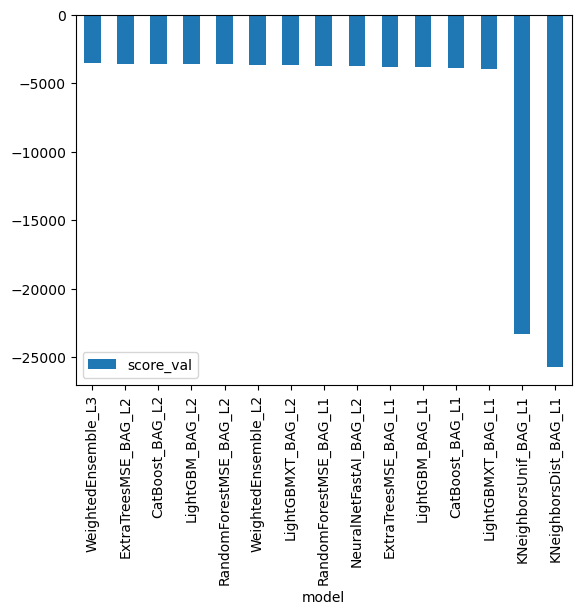

In [13]:
predictor.leaderboard(silent=True).plot(kind='bar', x='model', y='score_val');

In [14]:
predictions = predictor.predict(X_test)
predictions.head()

0    53498.851562
1    57104.890625
2    22888.542969
3     2636.444824
4     5946.329102
Name: price, dtype: float32

### Hyperparameter optimization

In [15]:
nn_options = {
    'num_epochs': 10,
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1)
}

gbm_options = {
    'num_boost_round': 100,
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36)
}

hyperparameters = {
    'GBM': gbm_options,
    'NN_TORCH': nn_options
}

hyperparameter_tune_kwargs = {
    'num_trials': 5,
    'scheduler' : 'local',
    'searcher': 'auto'
}

predictor_new_hpo = TabularPredictor(
    label='price',
    problem_type='regression',
    eval_metric='root_mean_squared_error'
).fit(
    train_data=X_train,
    time_limit=600,
    presets='best_quality',
    hyperparameters=hyperparameters,
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
)

Fitted model: NeuralNetTorch_BAG_L2/f95092db ...
	-4254.9031	 = Validation score   (-root_mean_squared_error)
	31.76s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: NeuralNetTorch_BAG_L2/09cac0ea ...
	-4632.1608	 = Validation score   (-root_mean_squared_error)
	32.65s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: NeuralNetTorch_BAG_L2/b430dbd2 ...
	-4624.5171	 = Validation score   (-root_mean_squared_error)
	76.07s	 = Training   runtime
	0.0s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L3 ... Training model for up to 360.0s of the 80.56s of remaining time.
	-4044.0931	 = Validation score   (-root_mean_squared_error)
	0.71s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 520.19s ... Best model: "WeightedEnsemble_L3"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20230619_192539/")


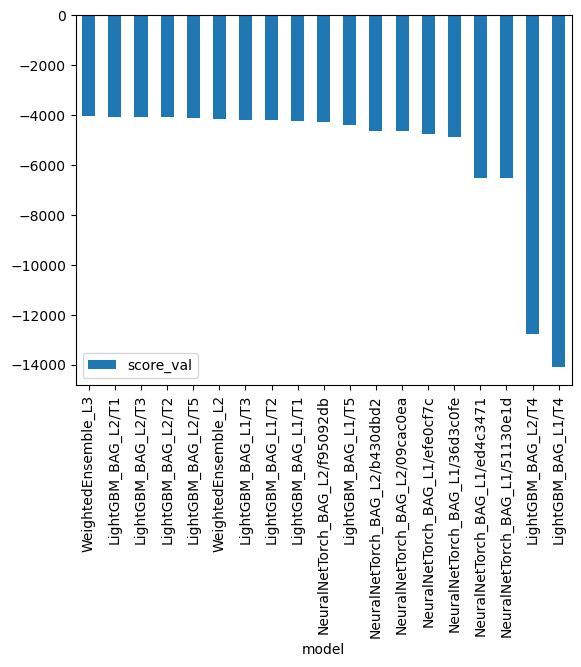

In [16]:
predictor_new_hpo.leaderboard(silent=True).plot(kind='bar', x='model', y='score_val');

In [17]:
predictions_hpo = predictor_new_hpo.predict(X_test)
predictions_hpo.head()

0    57440.972656
1    56034.644531
2    22191.996094
3     3068.433838
4     6286.215332
Name: price, dtype: float32

## Submission

In [18]:
sample_sub.head()

,id,price
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [19]:
sample_sub['price'] = predictions
sample_sub.to_csv("predictions_1.csv", index=False)
pd.read_csv("/kaggle/working/predictions_1.csv").head()

,id,price
0,1,53498.8500
1,2,57104.8900
2,3,22888.5430
3,4,2636.4448
4,5,5946.3290


In [20]:
sample_sub['price'] = predictions_hpo
sample_sub.to_csv("predictions_hpo_1.csv", index=False)
pd.read_csv("/kaggle/working/predictions_hpo_1.csv").head()

,id,price
0,1,57440.9730
1,2,56034.6450
2,3,22191.9960
3,4,3068.4338
4,5,6286.2153
